In [2]:
from qiskit import __version__
print(__version__)

1.4.2


In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile 
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError, pauli_error
from qiskit.circuit import Gate
from qiskit.circuit.library import HGate, UnitaryGate

In [4]:
# Create a UnitaryGate with Hadamard matrix but custom label
H_matrix = HGate().to_matrix()
h_tagged = UnitaryGate(H_matrix, label='h_targeted')

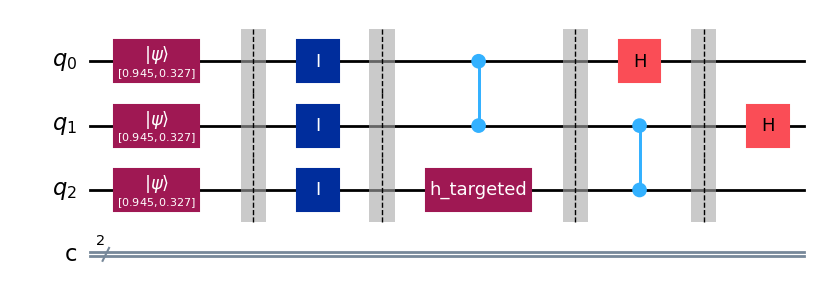

In [5]:
circuit = QuantumCircuit(3, 2)

# State prep
theta = np.arctan(np.sqrt((np.sqrt(5) - 1) / 2))
amp_0 = np.cos(theta/2)
amp_1 = np.sin(theta/2)

for i in range(3):
    circuit.initialize([amp_0, amp_1], i)
circuit.barrier()

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.append(h_tagged, [2])
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.cz(1,2)
circuit.barrier()

# Measure qubit 1 in X basis, and insert error on qubit 2
circuit.h(1)

display(circuit.draw(output='mpl'))

# Results without Noise

In [6]:
state_before_measurement = Statevector.from_instruction(circuit)
display(state_before_measurement.draw("latex"))

res, collapsed = state_before_measurement.measure([0, 1])
print("Measured: ", res)
display(collapsed.draw("latex"))

<IPython.core.display.Latex object>

Measured:  00


<IPython.core.display.Latex object>

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='47c37820-c1fb-4190-8613-1371b72c8ed4', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 192, '0x3': 70, '0x0': 436, '0x2': 302}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-162', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=4178587503, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 1, 'parallel_shots': 12, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.003731189, 'measure_sampling': False, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'enabled': True, 'threshold': 14, 'applied':

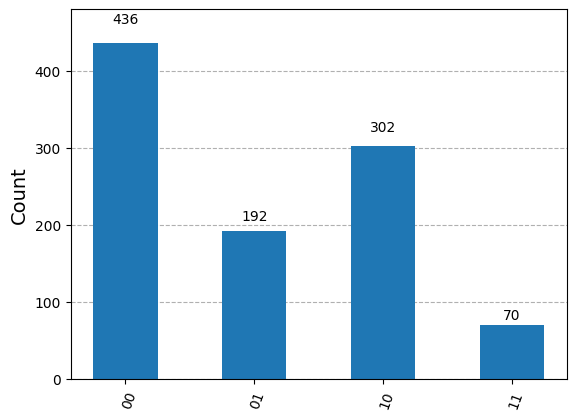

In [7]:
meas_circuit = circuit.copy()
meas_circuit.measure([0, 1], [0, 1])

backend = AerSimulator(method='statevector')

transpiled = transpile(meas_circuit, backend)

job = backend.run(transpiled,shots=1000)
result = job.result()
print(result)

counts = result.get_counts()
print(counts)
display(plot_histogram(counts)) 

In [8]:
right = counts['00']
wrong = counts['01'] + counts['10'] + counts['11']

print(f"Right Measurement Counts out of 1000: {right}")
print(f"Wrong Measurement Counts out of 1000: {wrong}")

Right Measurement Counts out of 1000: 436
Wrong Measurement Counts out of 1000: 564


# Results with Noise

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='af9bf310-9eda-4880-ab74-8bb428cfc68c', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 408, '0x3': 82, '0x2': 305, '0x1': 205}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=3.9269908169872423, memory_slots=2, n_qubits=3, name='circuit-162', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=2931160204, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 0.000287195, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.002488621, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'

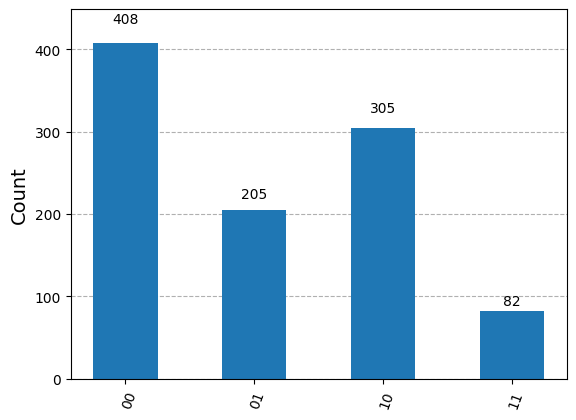

In [9]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05,1), ['h_targeted'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.07,2),['cz'])

# 2% chance of flipping 0 <-> 1
readout_err = ReadoutError([[0.95, 0.05],  # P(measured 0 | actual 0), P(1 | 0)
                            [0.05, 0.95]]) # P(0 | 1), P(1 | 1)

# Apply to all qubits being measured
noise_model.add_readout_error(readout_err, [0])
noise_model.add_readout_error(readout_err, [1])


meas_circuit_noise = circuit.copy()
meas_circuit_noise.measure([0, 1], [0, 1])

backend = AerSimulator(noise_model=noise_model)

transpiled = transpile(meas_circuit_noise, backend)

job = backend.run(transpiled,shots=1000)
result = job.result()
print(result)

counts_noise = result.get_counts()
print(counts_noise)
display(plot_histogram(counts_noise)) 

In [10]:
right = counts_noise['00']
wrong = counts_noise['01'] + counts_noise['10'] + counts_noise['11']

print(f"Right Measurement Counts out of 1000: {right}")
print(f"Wrong Measurement Counts out of 1000: {wrong}")

Right Measurement Counts out of 1000: 408
Wrong Measurement Counts out of 1000: 592


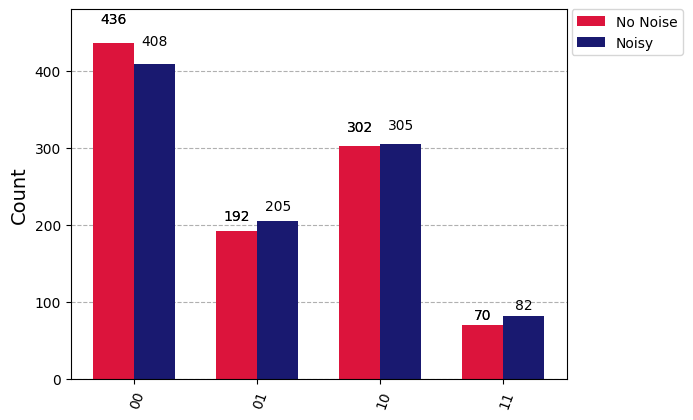

In [14]:
legend = ["No Noise", "Noisy"]
display(plot_histogram([counts, counts_noise], color=['crimson','midnightblue'], legend=legend))